# Fake News

## Import

In [1]:
import re
import time

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.read_csv('../american_datasets/cleaned/6.csv', index_col=0)
df.head()

title  \
0  Syria attack symptoms consistent with nerve ag...   
1  Homs governor says U.S. attack caused deaths b...   
2    Death toll from Aleppo bomb attack at least 112   
3        Aleppo bomb blast kills six Syrian state TV   
4  29 Syria Rebels Dead in Fighting for Key Alepp...   

                                                text label  
0  Wed 05 Apr 2017 Syria attack symptoms consiste...  True  
1  Fri 07 Apr 2017 at 0914 Homs governor says U.S...  True  
2  Sun 16 Apr 2017 Death toll from Aleppo bomb at...  True  
3  Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...  True  
4  Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...  True

In [3]:
df.shape

(804, 3)

## Visualization

(array([378.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 426.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

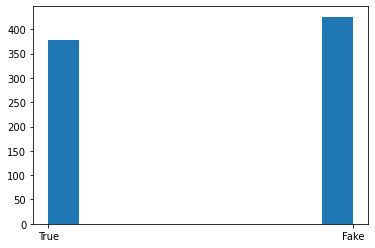

In [4]:
plt.hist(df['label'])

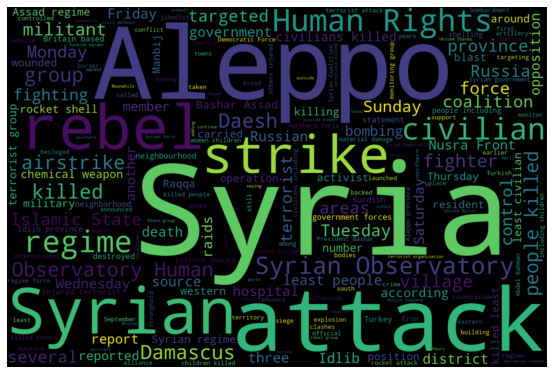

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

### Remove junk

In [6]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
0  syria attack symptoms consistent with nerve ag...   
1  homs governor says u s attack caused deaths bu...   
2       death toll from aleppo bomb attack at least    
3        aleppo bomb blast kills six syrian state tv   
4   syria rebels dead in fighting for key aleppo ...   

                                                text label  
0  wed apr syria attack symptoms consistent with ...  True  
1  fri apr at homs governor says u s attack cause...  True  
2  sun apr death toll from aleppo bomb attack at ...  True  
3  wed apr aleppo bomb blast kills six syrian sta...  True  
4  sun jul syria rebels dead in fighting for key ...  True

### Remove stop words

In [7]:
stop_words = set(stopwords.words("english"))


def remove_stop_words(text):
    res = []
    for word in text.split():
        if word not in stop_words:
            res.append(word)
    return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
0   syria attack symptoms consistent nerve agent use   
1  homs governor says u attack caused deaths does...   
2                death toll aleppo bomb attack least   
3        aleppo bomb blast kills six syrian state tv   
4         syria rebels dead fighting key aleppo road   

                                                text label  
0  wed apr syria attack symptoms consistent nerve...  True  
1  fri apr homs governor says u attack caused dea...  True  
2  sun apr death toll aleppo bomb attack least de...  True  
3  wed apr aleppo bomb blast kills six syrian sta...  True  
4  sun jul syria rebels dead fighting key aleppo ...  True

### Stemming

In [8]:
snowball_stemmer = SnowballStemmer(language='english')


def stemmer(text):
    res = []
    for word in text.split():
        res.append(snowball_stemmer.stem(word))
    return " ".join(res)


df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
0        syria attack symptom consist nerv agent use   
1  hom governor say u attack caus death doesnt se...   
2                death toll aleppo bomb attack least   
3         aleppo bomb blast kill six syrian state tv   
4             syria rebel dead fight key aleppo road   

                                                text label  
0  wed apr syria attack symptom consist nerv agen...  True  
1  fri apr hom governor say u attack caus death d...  True  
2  sun apr death toll aleppo bomb attack least de...  True  
3  wed apr aleppo bomb blast kill six syrian stat...  True  
4  sun jul syria rebel dead fight key aleppo road...  True

## ML Model

In [9]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1, 2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
for classifier in classifiers:
    start_time = time.time()
    
    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time 
    print_metrics(y_test, y_pred, training_time)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 0 s
1. Accuracy: 0.5455
2. Precision: 0.5353
3. Recall: 0.5351
4. F1 score: 0.5352
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake         84    54
True         56    48
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 1 s
1. Accuracy: 0.5165
2. Precision: 0.5074
3. Recall: 0.5074
4. F1 score: 0.5074
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake         79    59
True         58    46
---------------------------------
DecisionTreeClassifier()


0. Training time: 0 s
1. Accuracy: 0.5124
2. Precision: 0.5095
3. Recall: 0.5097
4. F1 score: 0.5083
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake         73    65
True         53    51
---------------------------------
AdaBoostClassifier()


0. Training time: 1 s
1. Accuracy: 0.5579
2. Precision: 0.5567
3. Recall: 0.5578
4. F1 score: 0.5551
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake         77    61
True         46    58
---------------------------------
KNeighborsClassifier(n_jobs=8)
0. Training time: 0 s
1. Accuracy: 0.4752
2. Precision: 0.474
3. Recall: 0.4735
4. F1 score: 0.472
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake         67    71
True         56    48
